In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import scanpy as sc
import pandas as pd
import multivae
from matplotlib import pyplot as plt
import umap
import seaborn as sns
import gc
import os
import tensorflow as tf
import keras
from sklearn.neural_network import MLPClassifier

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-package

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%config InlineBackend.figure_format='retina'

In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Load the Dataset

In [7]:
SCRNA_PATH = '../data/zhu-2019/Adult_Cerebrail_Cortex/Adult_CTX_RNA/expressions.h5ad'
SCATAC_PATH = '../data/zhu-2019/Adult_Cerebrail_Cortex/Adult_CTX_DNA/peaks-binary.h5ad'

## scRNA

In [8]:
%time scrna = sc.read_h5ad(SCRNA_PATH)
scrna

CPU times: user 224 ms, sys: 24 ms, total: 248 ms
Wall time: 672 ms


AnnData object with n_obs × n_vars = 14952 × 2693 
    obs: 'Rep', 'cell_type', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Rep_colors', 'cell_type_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'

## scATAC

In [9]:
%time scatac = sc.read_h5ad(SCATAC_PATH)
scatac

CPU times: user 144 ms, sys: 16 ms, total: 160 ms
Wall time: 501 ms


AnnData object with n_obs × n_vars = 15071 × 1002 
    obs: 'Rep', 'cell_type', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2', 'nb_features'
    var: 'gene_ids', 'commonness', 'n_cells', 'prop_shared_cells', 'variability_score'
    obsm: 'X_umap'

In [11]:
# TODO: remove this and set the condition of samples in the preprocessing notebook
scrna.obs['condition'] = 'normal'
scatac.obs['condition'] = 'normal'

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


# Train the model

In [12]:
network = multivae.archs.MultiTrVAE([scrna.shape[1], scatac.shape[1]],
                                    n_conditions=1,
                                    z_dimension=20,
                                    architecture=[128, 128, 64, 64],
                                    eta=1,
                                    alpha=0.001,
                                    gamma=1,
                                    beta=1,
                                    paired=True,
                                    output_activations=['relu', 'sigmoid'],
                                    reconstruction_losses=['mse', 'bce'],
                                    model_path='./models/multitrvae/zhu2019-acc/')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "multi_trvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data_0 (InputLayer)             (None, 2693)         0                                            
__________________________________________________________________________________________________
encoder_labels_0 (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
data_1 (InputLayer)             (None, 1002)         0                                            
__________________________________________________________________________________________________
encoder_labels_1 (InputLayer)   (None, 1)            0                                     

In [13]:
history = network.train([scrna, scatac], n_epochs=250, batch_size=64, verbose=2, lr_reducer=50, early_stop_limit=70)


Train on 11906 samples, validate on 2977 samples
Epoch 1/250
 - 40s - loss: 1124.9599 - decoder_0_loss: 125.8394 - decoder_1_loss: 244.8833 - decoder_0_recon_loss: 125.5827 - decoder_0_cross_loss_1: 253.9167 - decoder_0_cycle_loss_1: 125.6849 - decoder_0_kl_loss: 8.3392e-04 - decoder_0_modals_mmd_loss: 0.0327 - decoder_0_conditions_mmd_loss: 0.0000e+00 - decoder_1_recon_loss: 245.3951 - decoder_1_cross_loss_0: 125.8665 - decoder_1_cycle_loss_0: 248.4830 - decoder_1_kl_loss: 9.8128e-04 - decoder_1_modals_mmd_loss: 0.0327 - decoder_1_conditions_mmd_loss: 0.0000e+00 - val_loss: 888.0695 - val_decoder_0_loss: 117.5202 - val_decoder_1_loss: 170.8515 - val_decoder_0_recon_loss: 117.4235 - val_decoder_0_cross_loss_1: 193.1663 - val_decoder_0_cycle_loss_1: 120.7596 - val_decoder_0_kl_loss: 7.1340e-04 - val_decoder_0_modals_mmd_loss: 0.0361 - val_decoder_0_conditions_mmd_loss: 0.0000e+00 - val_decoder_1_recon_loss: 170.6575 - val_decoder_1_cross_loss_0: 119.9690 - val_decoder_1_cycle_loss_0: 1

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


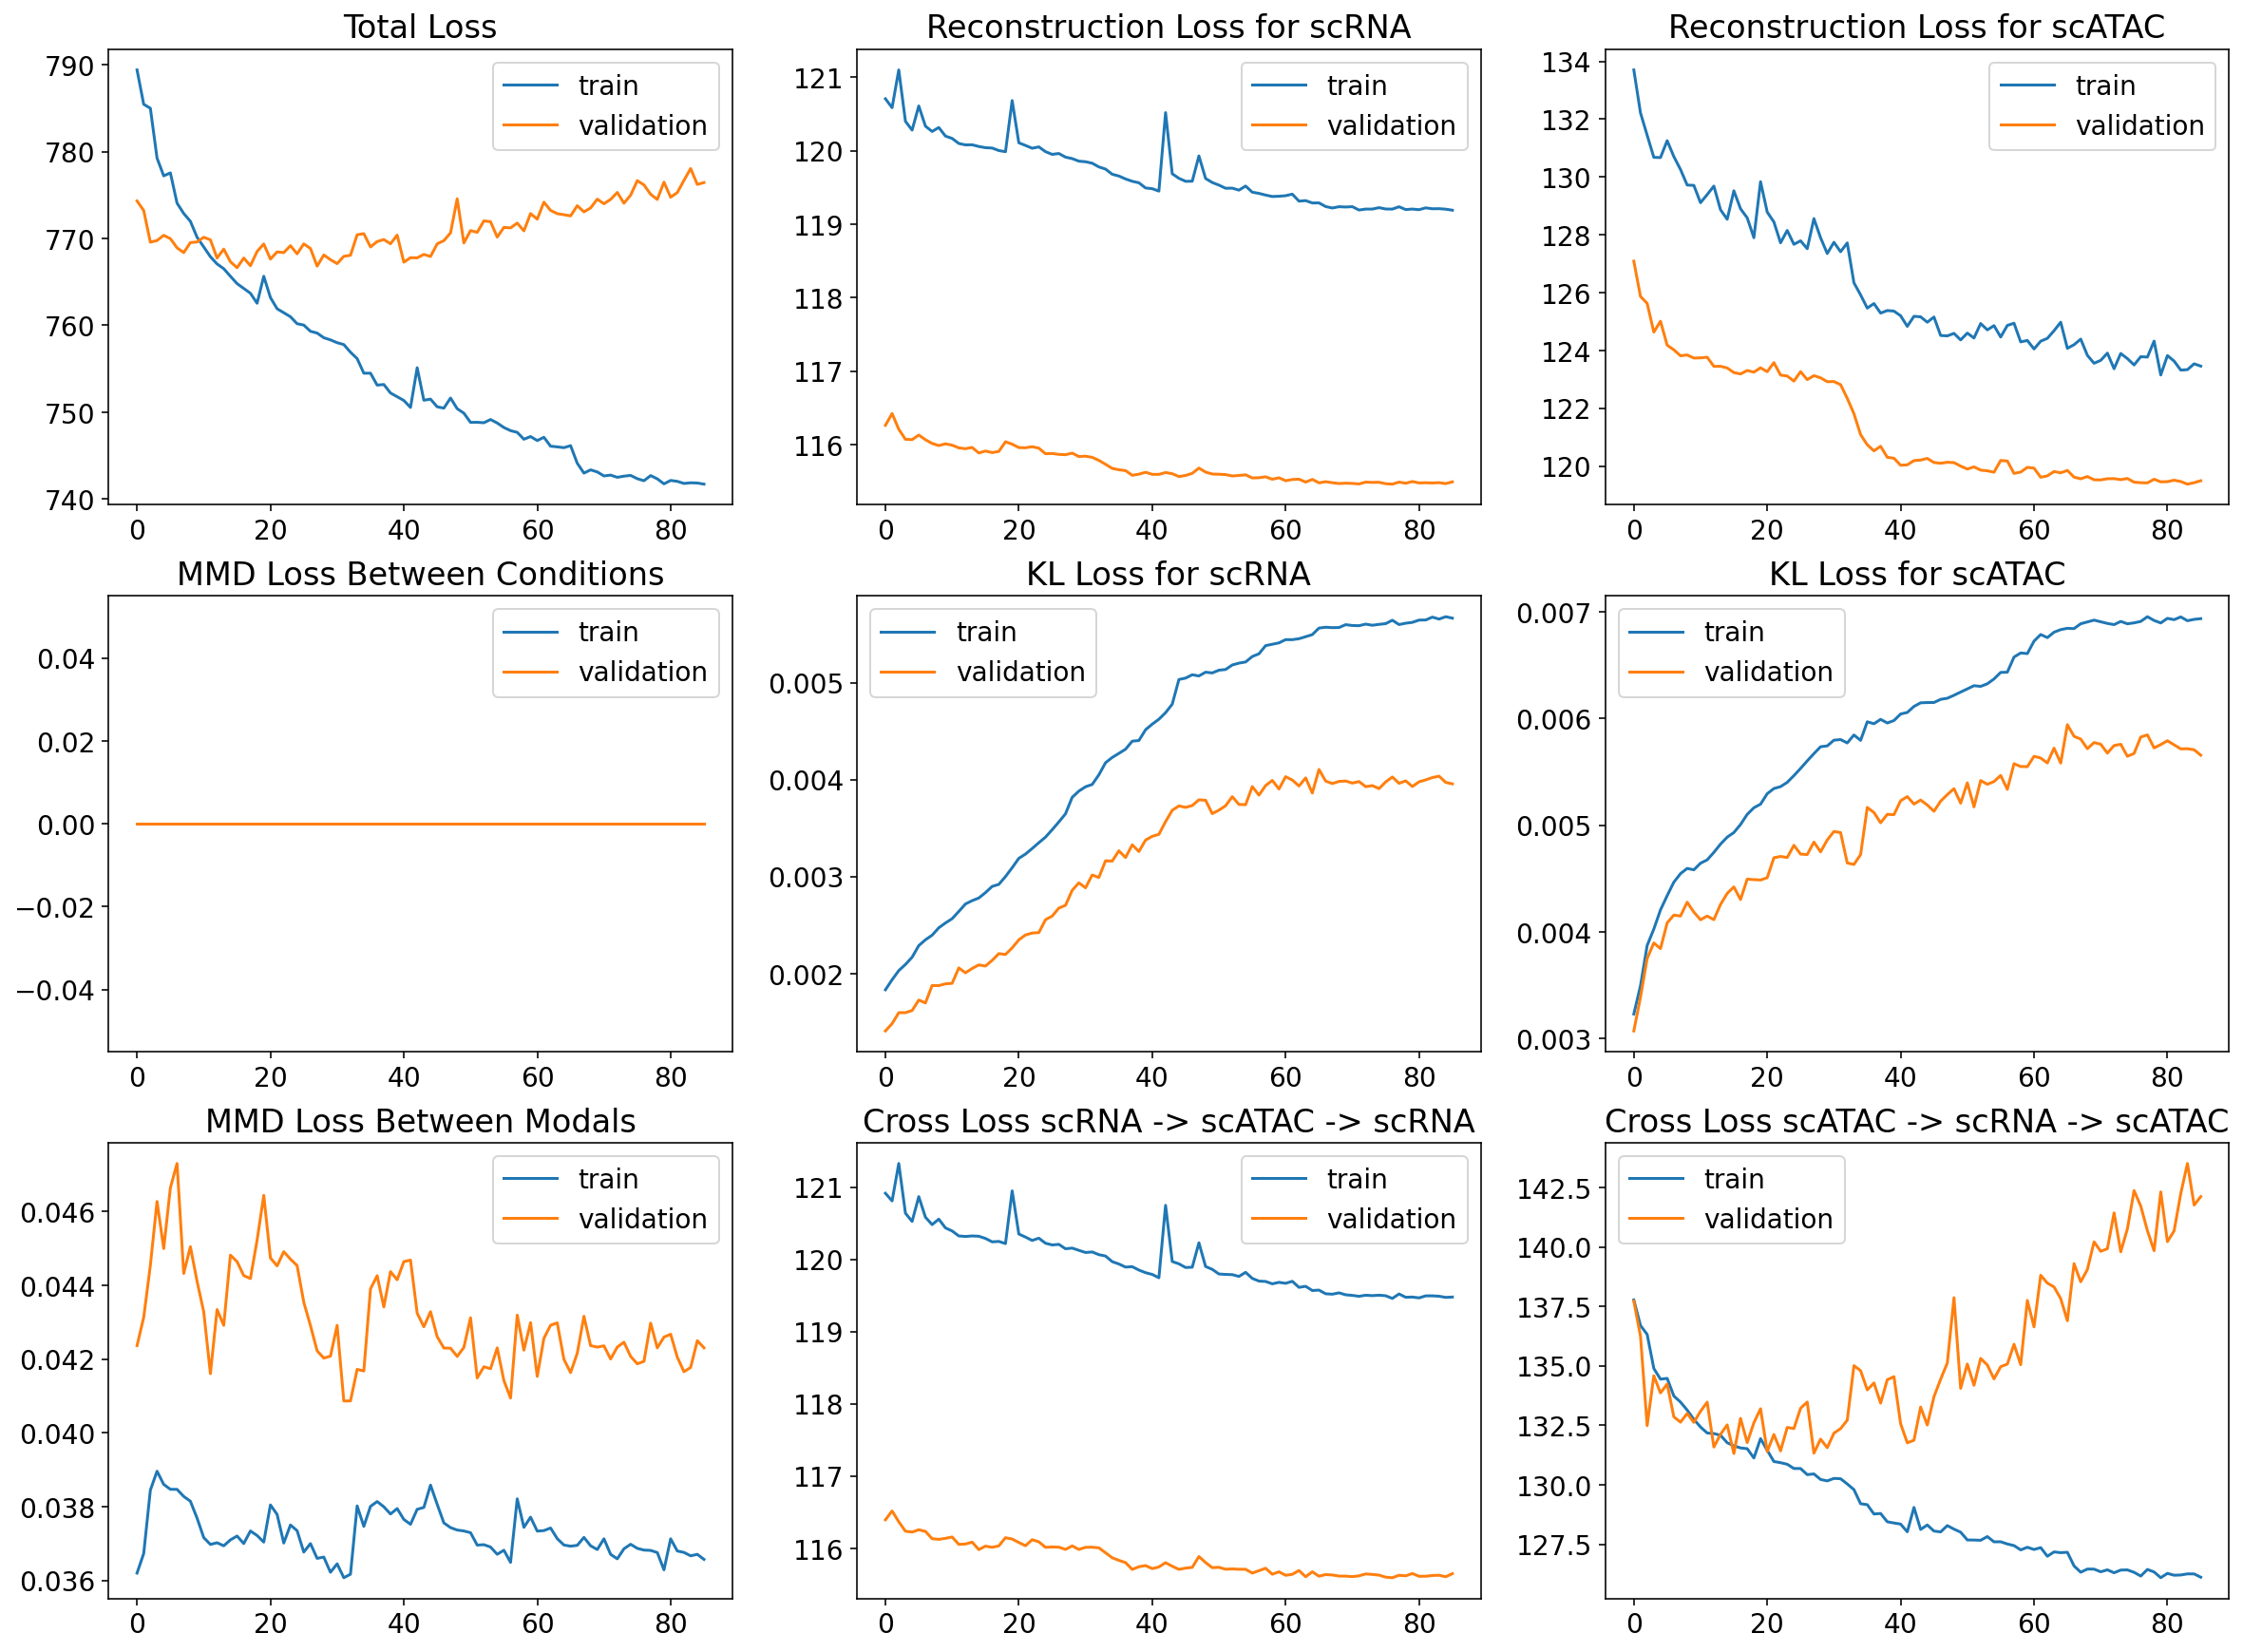

In [14]:
from_epoch = 5

plt.figure(figsize=(20, 15));

plt.subplot(3, 3, 1);
plt.plot(history.history['loss'][from_epoch:], label='train');
plt.plot(history.history['val_loss'][from_epoch:], label='validation')
plt.title('Total Loss')
plt.legend();

plt.subplot(3, 3, 2);
plt.plot(history.history['decoder_0_recon_loss'][from_epoch:], label='train');
plt.plot(history.history['val_decoder_0_recon_loss'][from_epoch:], label='validation');
plt.title('Reconstruction Loss for scRNA')
plt.legend();

plt.subplot(3, 3, 3);
plt.plot(history.history['decoder_1_loss'][from_epoch:], label='train');
plt.plot(history.history['val_decoder_1_loss'][from_epoch:], label='validation');
plt.title('Reconstruction Loss for scATAC')
plt.legend();

plt.subplot(3, 3, 4);
plt.plot(history.history['decoder_0_conditions_mmd_loss'][from_epoch:], label='train');
plt.plot(history.history['val_decoder_0_conditions_mmd_loss'][from_epoch:], label='validation')
plt.title('MMD Loss Between Conditions')
plt.legend();

plt.subplot(3, 3, 5);
plt.plot(history.history['decoder_0_kl_loss'][from_epoch:], label='train');
plt.plot(history.history['val_decoder_0_kl_loss'][from_epoch:], label='validation');
plt.title('KL Loss for scRNA')
plt.legend();

plt.subplot(3, 3, 6);
plt.plot(history.history['decoder_1_kl_loss'][from_epoch:], label='train');
plt.plot(history.history['val_decoder_1_kl_loss'][from_epoch:], label='validation')
plt.title('KL Loss for scATAC')
plt.legend();

plt.subplot(3, 3, 7);
plt.plot(history.history['decoder_0_modals_mmd_loss'][from_epoch:], label='train');
plt.plot(history.history['val_decoder_0_modals_mmd_loss'][from_epoch:], label='validation')
plt.title('MMD Loss Between Modals')
plt.legend();

plt.subplot(3, 3, 8);
plt.plot(history.history['decoder_0_cycle_loss_1'][from_epoch:], label='train');
plt.plot(history.history['val_decoder_0_cycle_loss_1'][from_epoch:], label='validation')
plt.title('Cross Loss scRNA -> scATAC -> scRNA')
plt.legend();

plt.subplot(3, 3, 9);
plt.plot(history.history['decoder_1_cycle_loss_0'][from_epoch:], label='train');
plt.plot(history.history['val_decoder_1_cycle_loss_0'][from_epoch:], label='validation')
plt.title('Cross Loss scATAC -> scRNA -> scATAC')
plt.legend();

# Visualization

## Latent space of scRNA-seq

In [15]:
scrna_encoder_labels, _ = multivae.utils.label_encoder(scrna, condition_key="condition")
scrna_latent = network.to_latent(scrna, scrna_encoder_labels, modal=0)

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anac

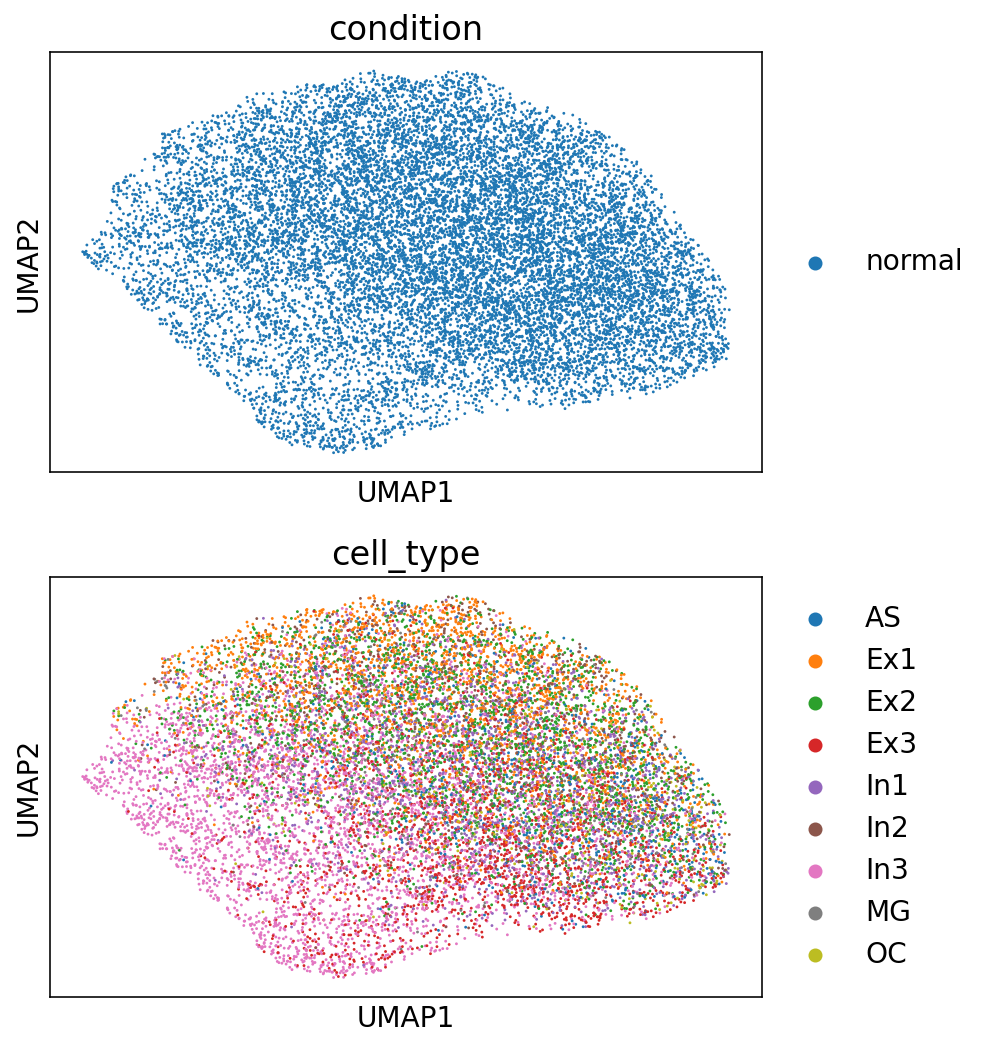

In [16]:
sc.pp.neighbors(scrna_latent, random_state=42)
sc.tl.umap(scrna_latent, random_state=42)
sc.pl.umap(scrna_latent, color=['condition', 'cell_type'], ncols=1)

## Latent space of scATAC-seq

In [17]:
scatac_encoder_labels, _ = multivae.utils.label_encoder(scatac, condition_key="condition")
scatac_latent = network.to_latent(scatac, scatac_encoder_labels, modal=1)

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
... storing 'condition' as categorical


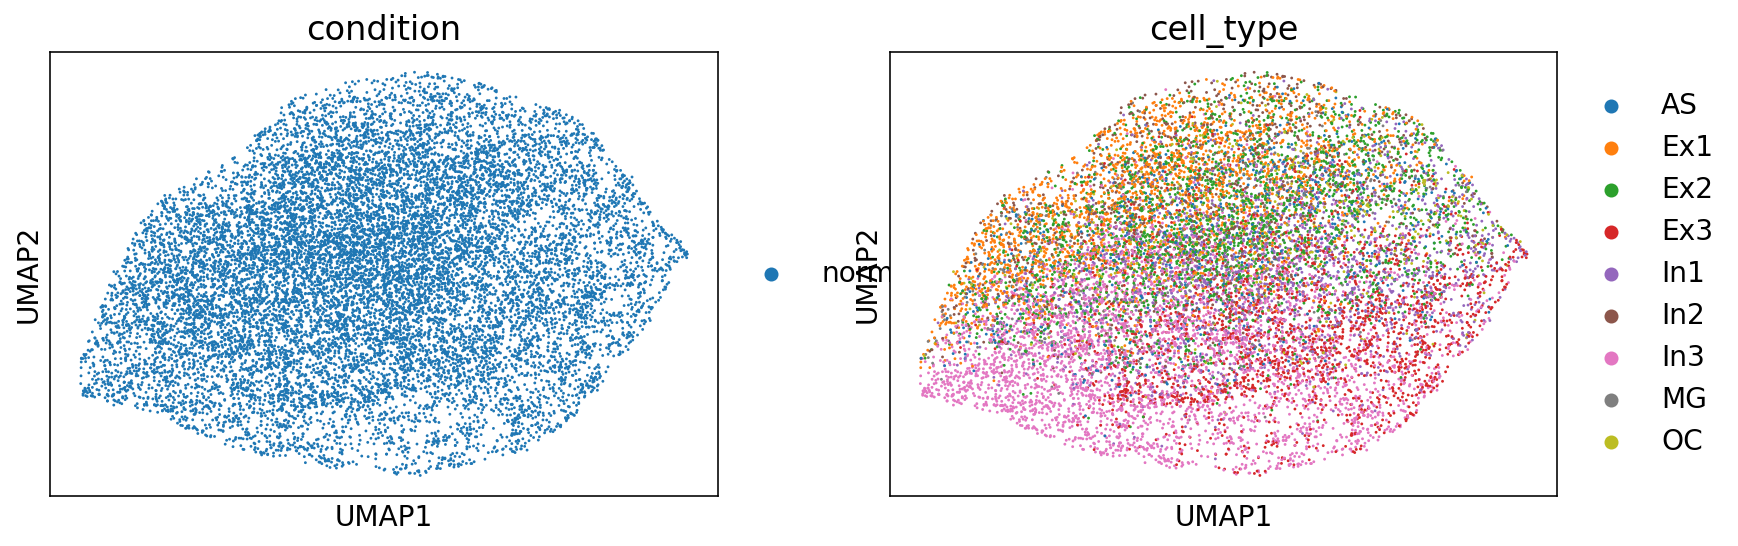

CPU times: user 32.5 s, sys: 1.28 s, total: 33.8 s
Wall time: 25.7 s


In [18]:
%%time
sc.pp.neighbors(scatac_latent, random_state=42)
sc.tl.umap(scatac_latent, random_state=42)
sc.pl.umap(scatac_latent, color=['condition', 'cell_type'])

## Latent space of both modalities

In [19]:
scall_latent = np.concatenate([scrna_latent.X, scatac_latent.X], axis=0)

scall_latent = sc.AnnData(scall_latent)
scrnaobs = scrna.obs.copy(deep=True)
scatacobs = scatac.obs.copy(deep=True)
scrnaobs['modality'] = 'scRNA-seq'
scatacobs['modality'] = 'scATAC-seq'

scall_latent.obs = pd.concat([scrnaobs, scatacobs])

In [20]:
scall_latent[scall_latent.obs.index == '01:30:88:16']

View of AnnData object with n_obs × n_vars = 2 × 20 
    obs: 'Rep', 'cell_type', 'Combined_Dim1', 'Combined_Dim2', 'DNA_Dim1', 'DNA_Dim2', 'RNA_Dim1', 'RNA_Dim2', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'condition', 'modality', 'nb_features'

In [21]:
scall_latent.obs.loc['01:30:88:16']

Rep cell_type  Combined_Dim1  Combined_Dim2  DNA_Dim1  DNA_Dim2  \
index                                                                         
01:30:88:16   2       In3       4.339384      -2.821956  0.634181  1.751429   
01:30:88:16   2       In3       4.339384      -2.821956  0.634181  1.751429   

             RNA_Dim1  RNA_Dim2  n_genes  n_genes_by_counts  \
index                                                         
01:30:88:16 -2.506224  1.900988    149.0              149.0   
01:30:88:16 -2.506224  1.900988      NaN                NaN   

             log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
index                                                                    
01:30:88:16                 5.010635         305.0            5.723585   
01:30:88:16                      NaN           NaN                 NaN   

             total_counts_mt  log1p_total_counts_mt  pct_counts_mt condition  \
index                                                                          
01:30:88:16              0.0                    0.0            0.0    normal   
01:30:88:16              NaN                    NaN            NaN    normal   

               modality  nb_features  
index                                 
01:30:88:16   scRNA-seq          NaN  
01:30:88:16  scATAC-seq        419.0

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
... storing 'condition' as categorical
... storing 'modality' as categorical


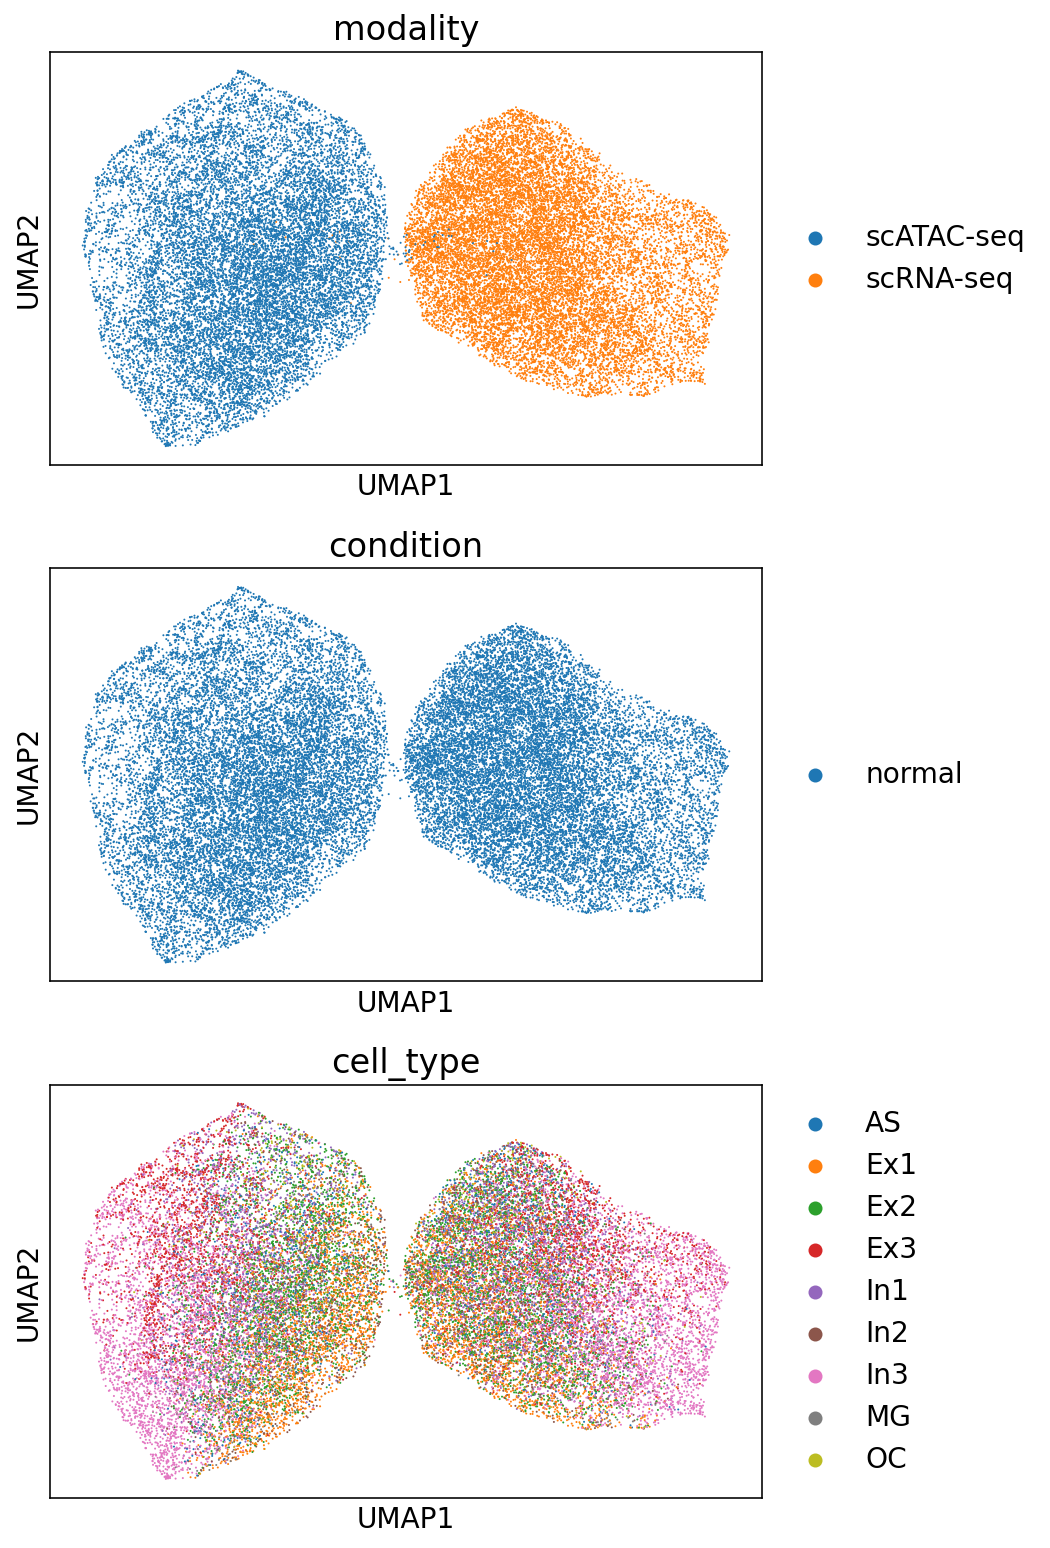

CPU times: user 1min 28s, sys: 3.3 s, total: 1min 32s
Wall time: 54.4 s


In [22]:
%%time
sc.pp.neighbors(scall_latent, random_state=42)
sc.tl.umap(scall_latent, random_state=42)
sc.pl.umap(scall_latent, color=['modality', 'condition', 'cell_type'], ncols=1)

# Classify Cell-types

In [53]:
cell_type_x = scall_latent.X
cell_type_y = keras.utils.to_categorical(scall_latent.obs['cell_type'].cat.codes, 9)
rna_indices = scall_latent.obs['modality'] == 'scRNA-seq'
atac_indices = scall_latent.obs['modality'] == 'scATAC-seq'

In [54]:
clsfr_scrna = MLPClassifier(learning_rate='adaptive', max_iter=1000, early_stopping=True, n_iter_no_change=80)
clsfr_scatac = MLPClassifier(learning_rate='adaptive', max_iter=1000, early_stopping=True, n_iter_no_change=80)
clsfr_scall = MLPClassifier(learning_rate='adaptive', max_iter=1000, early_stopping=True, n_iter_no_change=80)

In [55]:
clsfr_scrna.fit(cell_type_x[rna_indices], cell_type_y[rna_indices])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=80, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [56]:
clsfr_scatac.fit(cell_type_x[atac_indices], cell_type_y[atac_indices])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=80, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [57]:
clsfr_scall.fit(cell_type_x, cell_type_y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=80, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

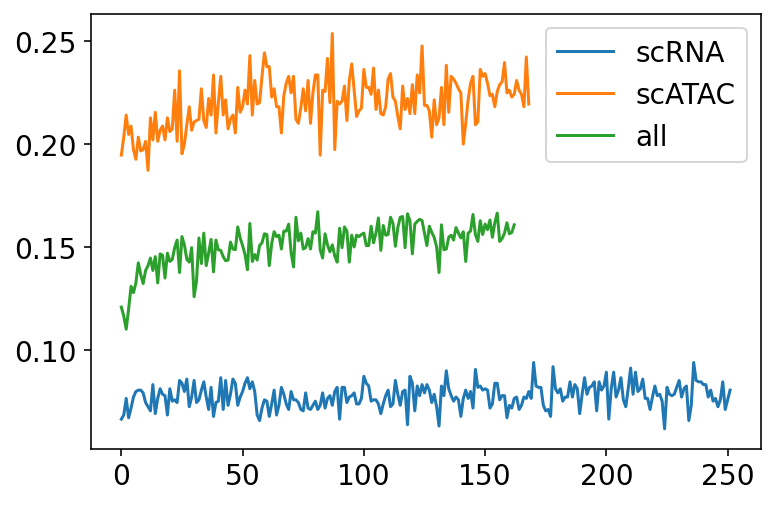

In [58]:
plt.plot(clsfr_scrna.validation_scores_, label='scRNA');
plt.plot(clsfr_scatac.validation_scores_, label='scATAC');
plt.plot(clsfr_scall.validation_scores_, label='all');
plt.legend();

In [59]:
clsfr_scrna.score(cell_type_x[atac_indices], cell_type_y[atac_indices])

0.07941947188066922

In [60]:
clsfr_scatac.score(cell_type_x[rna_indices], cell_type_y[rna_indices])

0.09554525297319089